# Deep Unmixing Autoencoder (DAEU) - PyTorch Implementation

Implementation of

B. Palsson, J. Sigurdsson, J. R. Sveinsson and M. O. Ulfarsson, "Hyperspectral Unmixing Using a Neural Network Autoencoder," in IEEE Access, vol. 6, pp. 25646-25656, 2018, doi: 10.1109/ACCESS.2018.2818280.


## Imports


In [1]:
%%capture
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.image import extract_patches_2d
from scipy import io as sio
import os
import numpy as np
from numpy.linalg import inv
import warnings
import matplotlib
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
# %matplotlib inline
import datetime
import time
import os
import numpy as np
import scipy.io as sio


from unmixing_pytorch import HSI, load_HSI, plotEndmembers, SAD
from unmixing_pytorch import (
    plotEndmembersAndGTV2,
    plotAbundancesSimpleGT,
    plotAbundancesSimpleV2,
    plotTrainingHistoryV2,
)

from models import Autoencoder, BetaVAE

from trainer import SADLoss


# Set device
device = torch.device("mps")
print(f"Using device: {device}")

# Set parameters
datasetnames = {"Samson": "Samson"}
dataset = "Samson"

hsi = load_HSI("./Datasets/" + datasetnames[dataset] + ".mat")
data = hsi.array()

# Base hyperparameters
num_endmembers = 3  # Samson dataset typically has 3 endmembers
num_spectra = 9025  # Number of spectra to sample for training

print(f"Dataset: {dataset}")
print(f"Data shape: {data.shape}")
print(f"Number of bands: {hsi.bands}")
print(f"Number of endmembers: {num_endmembers}")


In [2]:
try:
    from scipy.optimize import linear_sum_assignment
except ImportError:
    warnings.warn(
        "Scipy not installed. aSAM and aRMSE metrics will be unavailable. "
        "Please install it with: pip install scipy"
    )
    linear_sum_assignment = None


def _calculate_sam_degrees(v1, v2):
    """Calculates the Spectral Angle Mapper in degrees between two vectors."""
    cos_angle = np.clip(
        np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)), -1, 1
    )
    sam_rad = np.arccos(cos_angle)
    return np.rad2deg(sam_rad)


# --- Reconstruction RMSE (Simplified) ---


def compute_reconstruction_rmse(hsi, abundances, endmembers):
    original_image = hsi.image
    height, width, bands = original_image.shape
    num_pixels = height * width

    original_reshaped = original_image.reshape(num_pixels, bands)

    if abundances.ndim == 3:
        abundances_reshaped = abundances.reshape(num_pixels, -1)
    else:
        abundances_reshaped = abundances

    # Reconstruct: abundances @ endmembers
    reconstructed = abundances_reshaped @ endmembers

    # Compute RMSE
    mse = np.mean((original_reshaped - reconstructed) ** 2)
    return np.sqrt(mse)


def compute_unmixing_metrics(hsi, estimated_abundances, estimated_endmembers):

    original_image = hsi.image
    H, W, L = original_image.shape
    P = estimated_endmembers.shape[0]

    original_pixels = original_image.reshape(-1, L)
    estimated_abun_pixels = estimated_abundances.reshape(-1, P)

    gt_endmembers = hsi.gt
    gt_abun_pixels = hsi.abundances_map.reshape(-1, P)

    metrics = {}

    # 1. Reconstruction RMSE
    reconstructed_pixels = estimated_abun_pixels @ estimated_endmembers
    recon_mse = np.mean((original_pixels - reconstructed_pixels) ** 2)
    metrics["Reconstruction_RMSE"] = np.sqrt(recon_mse)

    # 2. aSAM and aRMSE
    if gt_endmembers is None or gt_abun_pixels is None or linear_sum_assignment is None:
        if linear_sum_assignment is None:
            warnings.warn("Scipy not installed. Skipping aSAM/aRMSE.")
        return metrics  # Return partial metrics

    # Cost Matrix (SAM)
    cost_matrix = np.zeros((P, P))
    for i in range(P):
        for j in range(P):
            cost_matrix[i, j] = _calculate_sam_degrees(
                estimated_endmembers[i, :], gt_endmembers[j, :]
            )

    est_indices, gt_indices = linear_sum_assignment(cost_matrix)

    metrics["aSAM_degrees"] = np.mean(cost_matrix[est_indices, gt_indices])

    reordered_abundances = estimated_abun_pixels[:, est_indices]
    abun_mse = np.mean((reordered_abundances - gt_abun_pixels) ** 2)
    metrics["Abundance_aRMSE"] = np.sqrt(abun_mse)

    return (
        metrics,
        est_indices,  # Permutation of estimated endmembers (0-indexed)
        gt_indices,  # Permutation of ground truth endmembers (0-indexed)
    )

In [3]:
def generate_run_parameters(base_params, run_number):
    """Generate parameters for a specific run with variations"""
    run_params = base_params.copy()
    # put run hyperparameters here
    param_variations = [
        {
            "learning_rate": 0.001,
            "batch_size": 25,
            "epochs": 14,
            "loss": SADLoss(),
            "beta": 0.00001,
            "latent_dist": "gaussian",
        },
    ]

    variation_idx = (run_number - 1) % len(param_variations)
    current_variation = param_variations[variation_idx]
    run_params.update(current_variation)
    run_params["run_number"] = run_number
    return run_params

In [4]:
def run_experiments():
    num_runs = 1
    plot_every = 2
    results_folder = "./Results"
    method_name = "unmixing_vae"

    session_timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    print(f"Starting experimental session: {session_timestamp}")

    for dataset in ["Samson"]:
        save_folder = os.path.join(results_folder, method_name, dataset)
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)

        hsi = load_HSI(f"./Datasets/{datasetnames[dataset]}.mat")
        data = hsi.array()

        base_params = {
            "num_endmembers": num_endmembers,
            "num_spectra": num_spectra,
            "data": hsi,
            "n_bands": hsi.bands,
            "GT": hsi.gt,
            # "loss": SADLoss(),  # choose loss function here
        }

        for run in range(1, num_runs + 1):
            print(f"\n=== Run {run}/{num_runs} ===")
            run_timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            run_params = generate_run_parameters(base_params, run)

            current_lr = run_params["learning_rate"]
            current_batch_size = run_params["batch_size"]
            current_epochs = run_params["epochs"]

            print(
                f"Parameters: LR={current_lr}, Batch={current_batch_size}, Epochs={current_epochs}"
            )
            print(f"Run timestamp: {run_timestamp}")

            run_params.update(
                {
                    "loss_type": type(run_params["loss"]).__name__,
                    "batch_size": current_batch_size,
                    "epochs": current_epochs,
                    "lr": current_lr,
                    "timestamp": run_timestamp,
                    "session_timestamp": session_timestamp,
                }
            )

            training_data = data[np.random.randint(0, data.shape[0], num_spectra), :]

            start_time = time.time()
            # choose model here
            # autoencoder = Autoencoder(run_params)
            autoencoder = BetaVAE(run_params)

            optimizer = optim.RMSprop(autoencoder.parameters(), lr=current_lr)
            run_params["optimizer"] = optimizer

            save_name = f"DAEU_{dataset}_run{run}_{run_timestamp}_lr{current_lr}_bs{current_batch_size}_ep{current_epochs}.mat"
            save_path = os.path.join(save_folder, save_name)

            # number of parameters
            total_params = sum(p.numel() for p in autoencoder.parameters())
            trainable_params = sum(
                p.numel() for p in autoencoder.parameters() if p.requires_grad
            )
            print(f"Total parameters: {total_params:,}")
            print(f"Trainable parameters: {trainable_params:,}")

            print("Training model...")
            history = autoencoder.fit(training_data, plot_every)
            training_time = time.time() - start_time

            endmembers = autoencoder.get_endmembers()
            abundances = autoencoder.get_abundances()

            run_suffix = f"Run {run} - {run_timestamp} (LR:{current_lr}, Batch:{current_batch_size}, Epochs:{current_epochs})"

            save_params = {
                k: v
                for k, v in run_params.items()
                if k not in ["optimizer", "loss", "data", "GT"]
            }
            save_params.update(
                {
                    "optimizer_type": "RMSprop",
                    "dataset": dataset,
                    "method": method_name,
                    "training_time_seconds": training_time,
                    "final_loss": history[-1] if history else float("inf"),
                }
            )

            params_to_save = save_params

            sio.savemat(
                save_path,
                {
                    "M": endmembers,
                    "A": abundances,
                    "parameters": params_to_save,  # Save the robust structured array
                    "training_loss": np.array(history),
                },
            )

            print(f"Training completed in {training_time:.2f} seconds")
            print(f"Results saved to: {save_path}")
            del autoencoder

            (
                performance_report,
                est_indices,
                gt_indices,
            ) = compute_unmixing_metrics(hsi, abundances, endmembers)

            print("Unmixing Performance Report:")
            for metric, value in performance_report.items():
                print(f"  - {metric}: {value:.4f}")

            # Plotting
            plotEndmembersAndGTV2(
                endmembers[est_indices], hsi.gt[gt_indices], title_suffix=run_suffix
            )

            plotAbundancesSimpleGT(
                abundances[:, :, est_indices],
                hsi.abundances_map.transpose(1, 0, 2)[:, :, gt_indices],
                title_suffix=run_suffix,
                colormap="plasma",
            )
            plotTrainingHistoryV2(history, title_suffix=run_suffix)

    print(f"\nExperimental session {session_timestamp} completed!")


def structured_array_to_dict(structured_array):
    result = {}
    for name in structured_array.dtype.names:
        value = structured_array[name][0][0]  # Access the first (and only) element
        result[name] = value.item() if hasattr(value, "item") else value
    return result


def load_timestamped_run(run_file_path, dataset_path=None):
    """Load and plot results from a timestamped run, failing if parameters are invalid."""
    results = sio.loadmat(run_file_path)

    endmembers = results["M"]
    abundances = results["A"]
    training_loss = results["training_loss"].flatten()

    print(f"Loaded results from: {os.path.basename(run_file_path)}")

    # Use the robust parser; this will raise an error on failure
    # params_dict = _parse_parameters(results["parameters"])

    params_dict = structured_array_to_dict(results["parameters"])

    lr = params_dict.get("lr", params_dict.get("learning_rate", "Unknown"))
    batch_size = params_dict.get("batch_size", "Unknown")
    epochs = params_dict.get("epochs", "Unknown")
    run_number = params_dict.get("run_number", "Unknown")
    timestamp = params_dict.get("timestamp", "Unknown")

    title_suffix = (
        f"Run {run_number} - {timestamp} (LR:{lr}, Batch:{batch_size}, Epochs:{epochs})"
    )

    print("Run details:")
    for param_key, param_value in params_dict.items():
        print(f"  - {param_key}: {param_value}")

    hsi = load_HSI(dataset_path)

    # Calculate the performance metrics
    performance_report, est_indices, gt_indices = compute_unmixing_metrics(
        hsi, abundances, endmembers
    )

    # Print the results
    print("Unmixing Performance Report:")
    for metric, value in performance_report.items():
        print(f"  - {metric}: {value:.4f}")

    plotTrainingHistoryV2(training_loss.tolist(), title_suffix=title_suffix)
    plotAbundancesSimpleGT(
        abundances[:, :, est_indices],
        hsi.abundances_map.transpose(1, 0, 2)[:, :, gt_indices],
        title_suffix=title_suffix,
        colormap="plasma",
    )
    plotEndmembersAndGTV2(
        endmembers[est_indices], hsi.gt[gt_indices], title_suffix=title_suffix
    )

    return (
        endmembers[est_indices],
        abundances[:, :, est_indices],
        hsi.gt[gt_indices],
        hsi.abundances_map.transpose(1, 0, 2)[:, :, gt_indices],
        params_dict,
        training_loss,
    )

Starting experimental session: 20251029_233414

=== Run 1/1 ===
Parameters: LR=0.001, Batch=25, Epochs=14
Run timestamp: 20251029_233414
Total parameters: 5,391
Trainable parameters: 5,391
Training model...
Epoch 2/14, Loss: 1.690580, Beta: 0.0000
Epoch 4/14, Loss: 0.080381, Beta: 0.0000
Epoch 6/14, Loss: 0.073147, Beta: 0.0000
Epoch 8/14, Loss: 0.068525, Beta: 0.0000
Epoch 10/14, Loss: 0.063302, Beta: 0.0000
Epoch 12/14, Loss: 0.060145, Beta: 0.0000
Epoch 14/14, Loss: 0.060627, Beta: 0.0000
Training completed in 16.02 seconds
Results saved to: ./Results/unmixing_vae/Samson/DAEU_Samson_run1_20251029_233414_lr0.001_bs25_ep14.mat
Unmixing Performance Report:
  - Reconstruction_RMSE: 0.1637
  - aSAM_degrees: 1.3507
  - Abundance_aRMSE: 0.5365


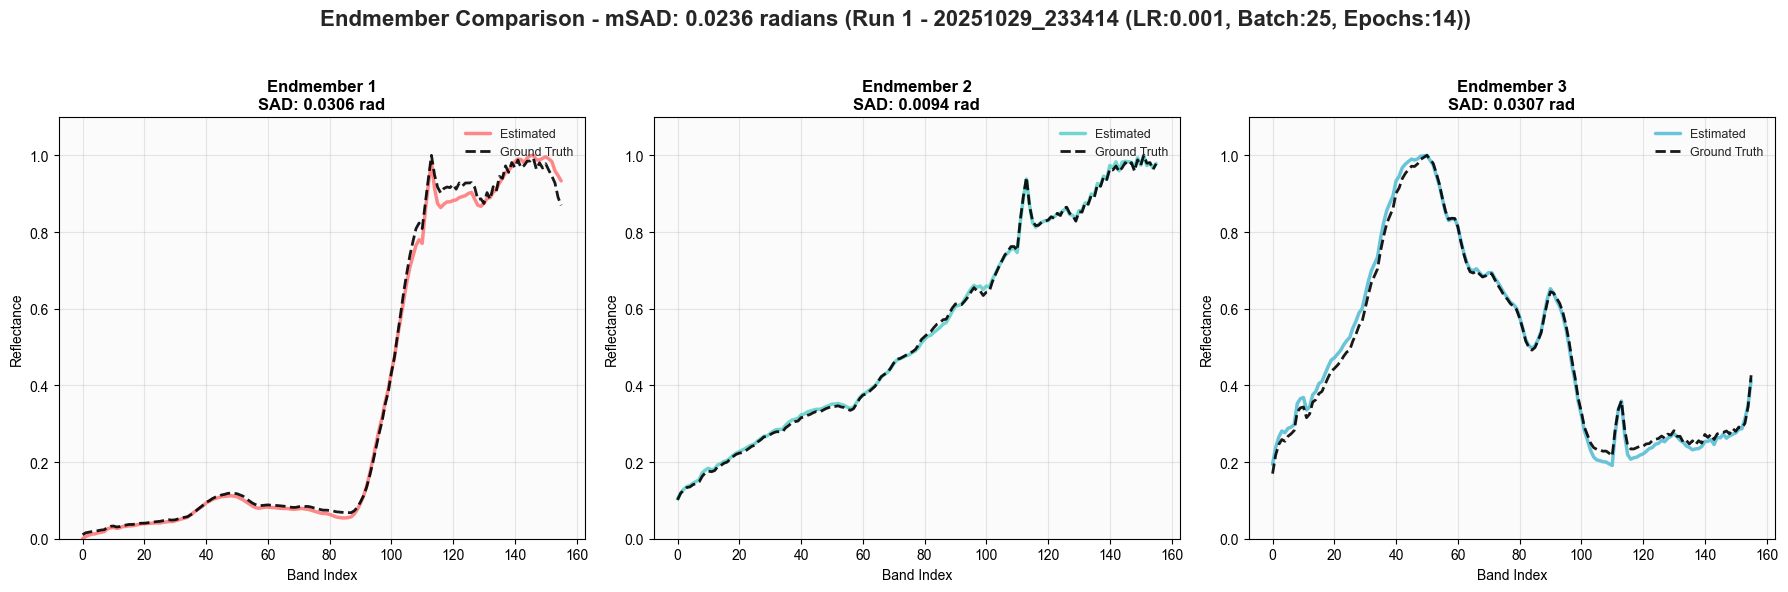

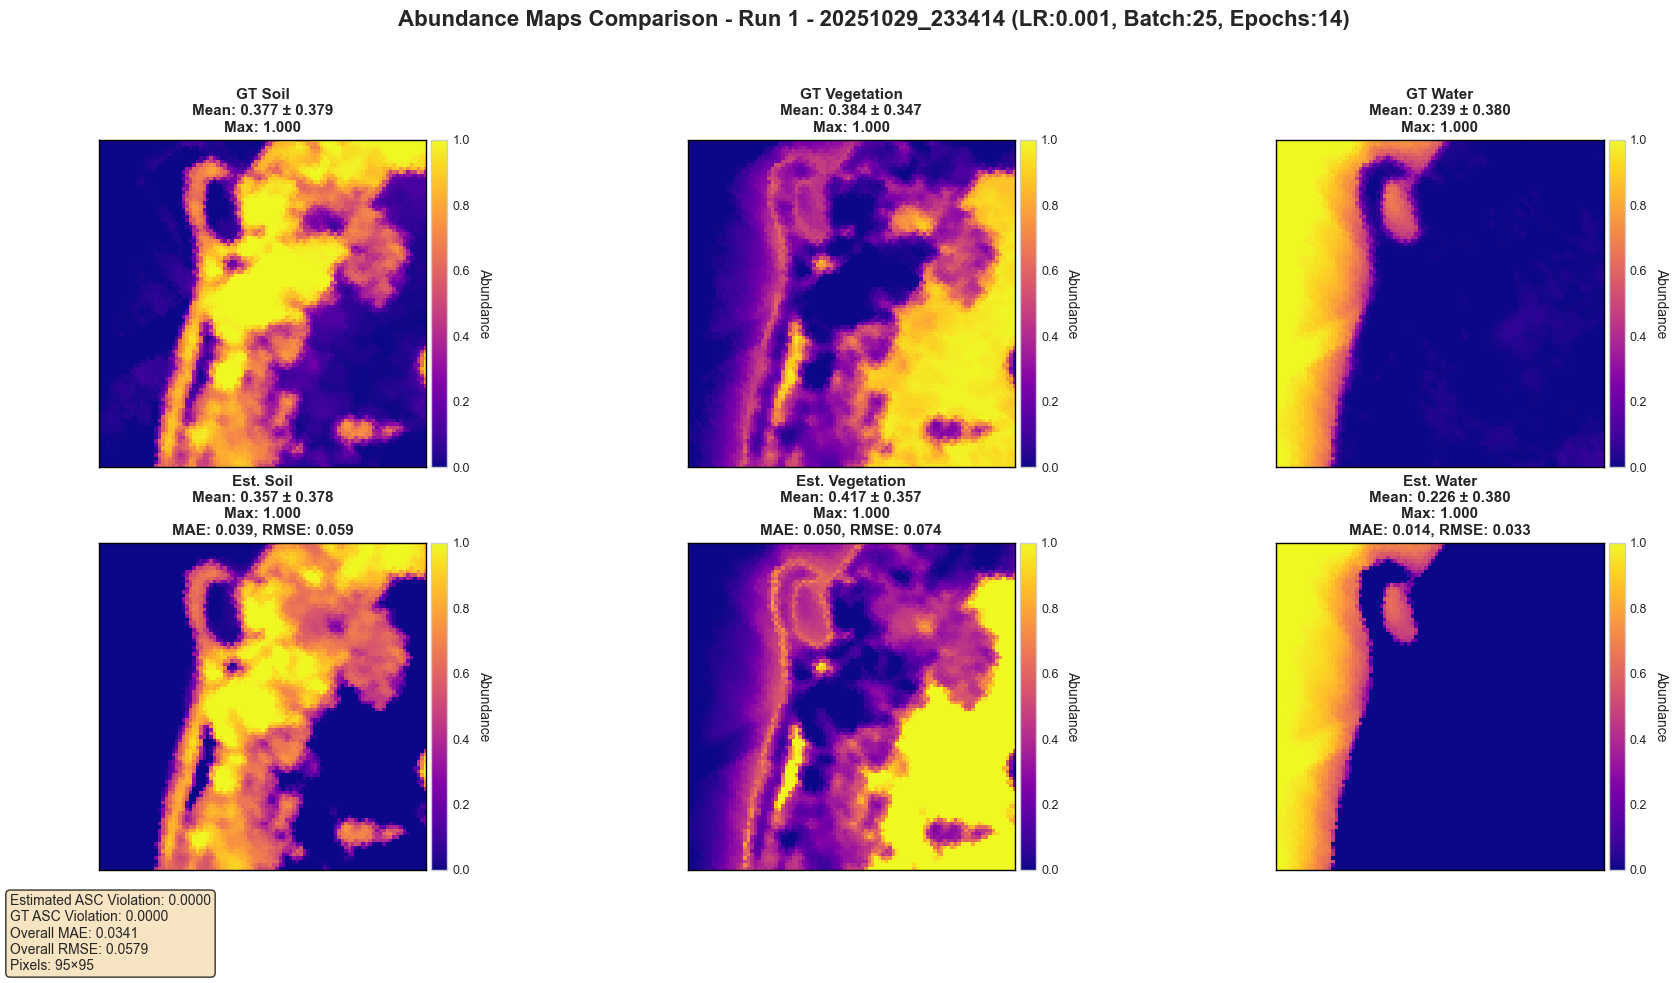

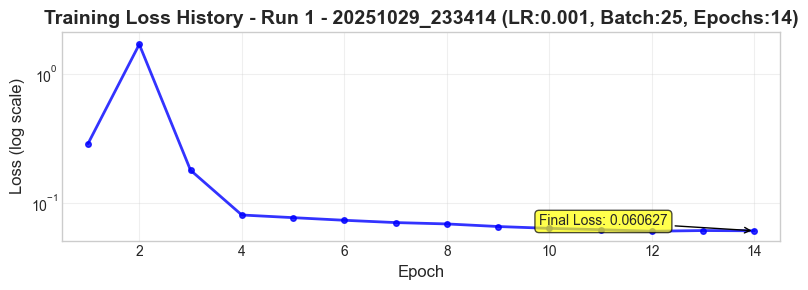


Experimental session 20251029_233414 completed!


In [5]:
dataset_path = "./Datasets/Samson.mat"

# To run a new set of experiments:
run_experiments()